In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import h5py
import pandas as pd
import numpy as np
import copy
import os
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [36]:
# daa = load_data('2018092_20180930')
# format1_path = 'data_format1_' + '20181007_20181014' + '.h5'
# f1_data = pd.HDFStore(os.path.join(data_root, format1_path))


Python 3.7.0


In [2]:
data_root = '../../data/'
root = './'
model_folder = './models/'
report_folder = './report_rc/'

In [6]:
'''
format1: {currency_type: {time: ['close', 'high', 'low', 'open', 'volume']}}
format2: {time: {currency_type: ['close', 'high', 'low', 'open', 'volume']}}
'''

def load_data(date_list):
    data_root = '../../data/'
    currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
    curr_info = dict.fromkeys(currencies)
    
    date_list = date_list if type(date_list) is list else [date_list]
    
    for date in date_list:
        print(f'load data from {date}')
        format1_path = 'data_format1_' + date + '.h5'
        f1_data = pd.HDFStore(os.path.join(data_root, format1_path))

        for curr in currencies:
            if curr_info[curr] is None:
                curr_info[curr] = f1_data[curr]
            else:
                curr_info[curr] = curr_info[curr].append(f1_data[curr])
        f1_data.close()
        
    for key, item in curr_info.items():
        curr_info[key]['volume_minmax'] = MinMaxScaler().fit_transform(item[['volume']]).reshape(1,-1)[0]        
        curr_info[key]['avg'] = item[['close', 'high', 'low', 'open']].mean(axis=1)
        
    return curr_info # {curr_name: cur_df}

def load_h5(date):
    data_root = './drive/Colab Notebooks/data/'
    format1_path = 'data_format1_' + date + '.h5'
    format2_path = 'data_format2_' + date + '.h5'
    
    f1_data = h5py.File(os.path.join(data_root, format1_path), 'r')
    f2_data = h5py.File(os.path.join(data_root, format2_path), 'r')
    
    return f1_data, f2_data
    

In [7]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
data['BCH-USD'].head()

In [18]:
date_list = ['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808',
             '20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
             '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
             '20181028_20181104', '20181104_20181111']
# date_list = ['20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
#              '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
#              '20181028_20181104', '20181104_20181111']

data = load_data(date_list)

load data from 201801
load data from 201802
load data from 201803
load data from 201804
load data from 201805
load data from 201806
load data from 201807
load data from 201808
load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111


In [32]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

for curr in currencies:
    data[curr] = data[curr].reset_index()
    data[curr] = data[curr].drop_duplicates(subset='time', keep='first')
    data[curr] = data[curr].set_index('time')

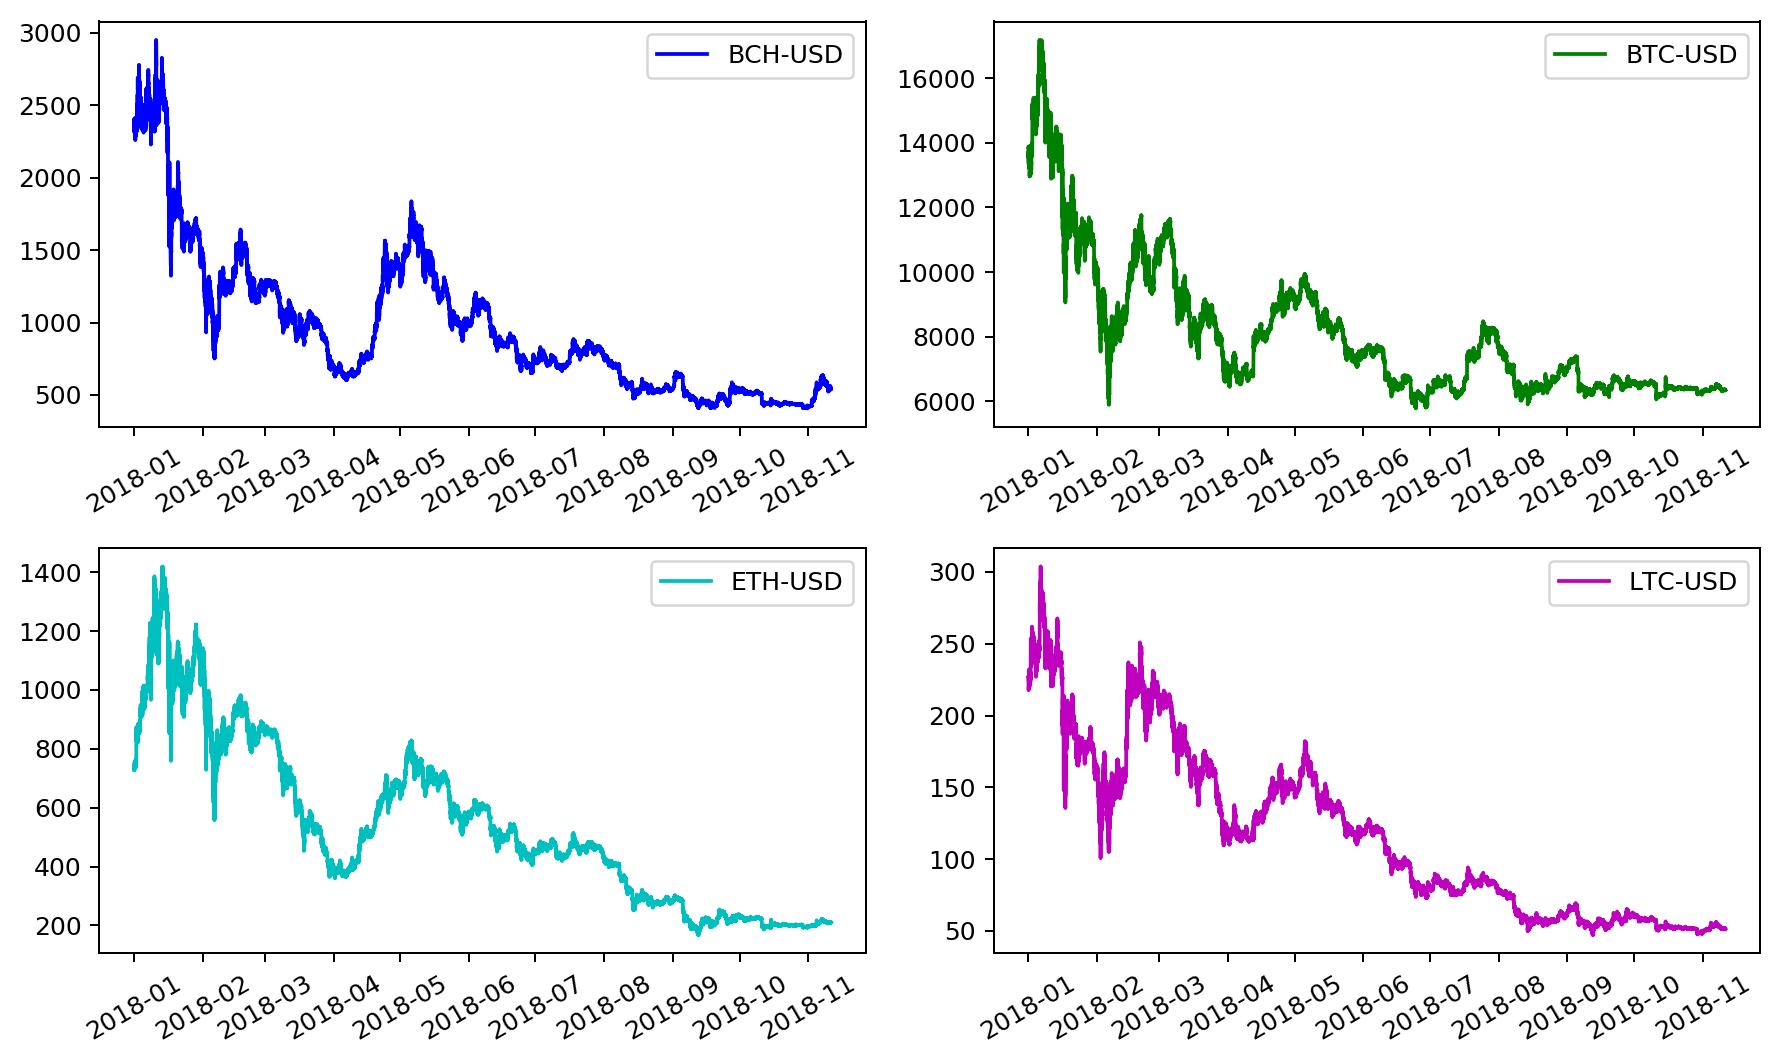

In [33]:
plt.figure(figsize=(10, 6), dpi=180)
colors = ['b', 'g', 'c', 'm']
for i in range(4):
    curr = currencies[i]
    color = colors[i]
    plt.subplot(2,2,i+1)
    plt.plot(data[curr].index, data[curr][['avg']], color, label=curr)
    plt.axis('tight')
    plt.legend()
    plt.xticks(rotation=60)
    
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'Average_Prices_of_Currencies_1801_1812.jpg'))
plt.show()

## Modeling

In [126]:
from keras.models import Sequential, load_model
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, Flatten

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split 

In [73]:
def build_model(dims_per_layer):
    loss_func = 'mse'
    optimiser_func = 'adam' # 'rmsprop'
    activation_func = 'tanh'  # tanh
    
    rnn_model = Sequential()

    # Plan A
    rnn_model.add(LSTM(
                input_dim=dims_per_layer[0],
                output_dim=64,
                return_sequences=True))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(LSTM(128, return_sequences=True))
    rnn_model.add(Dropout(0.2))
    
    rnn_model.add(LSTM(64, return_sequences=False))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(Dense(output_dim=1))
    rnn_model.add(Activation(activation_func))
 
    rnn_model.compile(loss=loss_func, optimizer=optimiser_func)
    return rnn_model

def train_model(model_name, train_x, train_y, val_data, epoches=100, batch_size=4):
    
    model = build_model([train_x.shape[-1], 128, 64, 1])
    history = model.fit(train_x, train_y, epochs=epoches, batch_size=batch_size, validation_data=val_data, verbose=2, shuffle=False)

    model.save(os.path.join(model_folder, f'./{model_name}.h5'))
    return model, history
    

def split_train_xy(df, window_x, window_y, stride=1):
    train_x = []
    train_y = []
    i = 0
    while(i+window_x+window_y < len(df)):
        train_x = train_x.append((df[i:(i+window_x)][['open', 'close', 'high', 'low', 'volume_minmax']]).values)
#         train_y.append(df[(i+window_x):(i+window_x+window_y)][['avg']])
        train_y = train_y.append((df.iloc[(i+window_x+window_y)][['avg']]).values)
        
        i += stride
                
    return train_x, train_y


In [99]:
# build model & prepare train test data set
def create_dataset(dataset, look_back=60, look_forward=60):
    data_x = []
    data_y = [] # value changed of next look_forward duration
    i = 0
    while i < len(dataset)-look_back-look_forward-1:
        x = []
        index = i
        for j in range(4):
            start = i+int(look_back*j/4)
            end = i+int(look_back*(j+1)/4)
            x.append(dataset[start:end, 0].mean())
        data_x.append(x)
#         y = [dataset[i+look_back, 0], dataset[i+look_back+look_forward, 0]]
        y = dataset[i+look_back:i+look_back+look_forward, 0].mean()
        data_y.append(y)
        i += look_forward
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_x = scaler.fit_transform(data_x)   
        
    return np.array(data_x), np.array(data_y)

# def create_simple_dataset(dataset, look_back=1, look_forward=1):
#     data_x = []
#     data_y = [] # value changed of next look_forward duration
#     i = 0
#     while i < len(dataset)-look_back-look_forward-1:
#         x = dataset[i:(i+look_back), 0]
#         data_x.append(x)
# #         y = [dataset[i+look_back, 0], dataset[i+look_back+look_forward, 0]]
#         y = dataset[i+look_back, 0]
#         data_y.append(y)
#         i += look_forward
        
#     return np.array(data_x), np.array(data_y)

In [100]:
## Increasing Window size

# date_list = ['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808',
#              '20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
#              '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
#              '20181028_20181104', '20181104_20181111']
date_list = ['20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
             '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
             '20181028_20181104', '20181104_20181111']

data = load_data(date_list)
data_test = load_data('20181111_20181118')

load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111
load data from 20181111_20181118


BCH-USD data processing
(1701, 1, 4)
BCH-USD model training
Train on 1701 samples, validate on 165 samples
Epoch 1/40
 - 6s - loss: 240725.4419 - val_loss: 217499.1588
Epoch 2/40
 - 0s - loss: 240094.0670 - val_loss: 217454.3065
Epoch 3/40
 - 0s - loss: 240086.3519 - val_loss: 217453.4098
Epoch 4/40
 - 0s - loss: 240085.8298 - val_loss: 217453.1323
Epoch 5/40
 - 0s - loss: 240085.6082 - val_loss: 217452.9986
Epoch 6/40
 - 0s - loss: 240085.5038 - val_loss: 217452.9332
Epoch 7/40
 - 0s - loss: 240085.4268 - val_loss: 217452.9071
Epoch 8/40
 - 0s - loss: 240085.3760 - val_loss: 217452.8744
Epoch 9/40
 - 0s - loss: 240085.3575 - val_loss: 217452.8583
Epoch 10/40
 - 0s - loss: 240085.3310 - val_loss: 217452.8453
Epoch 11/40
 - 0s - loss: 240085.3204 - val_loss: 217452.8418
Epoch 12/40
 - 0s - loss: 240085.3157 - val_loss: 217452.8287
Epoch 13/40
 - 0s - loss: 240085.3007 - val_loss: 217452.8287
Epoch 14/40
 - 0s - loss: 240085.2934 - val_loss: 217452.8287
Epoch 15/40
 - 0s - loss: 240085.2

Epoch 47/100
 - 0s - loss: 46493.0471 - val_loss: 36007.1873
Epoch 48/100
 - 0s - loss: 46493.0467 - val_loss: 36007.1873
Epoch 49/100
 - 0s - loss: 46493.0475 - val_loss: 36007.1865
Epoch 50/100
 - 0s - loss: 46493.0470 - val_loss: 36007.1861
Epoch 51/100
 - 0s - loss: 46493.0469 - val_loss: 36007.1857
Epoch 52/100
 - 0s - loss: 46493.0473 - val_loss: 36007.1852
Epoch 53/100
 - 0s - loss: 46493.0469 - val_loss: 36007.1848
Epoch 54/100
 - 0s - loss: 46493.0458 - val_loss: 36007.1848
Epoch 55/100
 - 0s - loss: 46493.0464 - val_loss: 36007.1844
Epoch 56/100
 - 0s - loss: 46493.0458 - val_loss: 36007.1840
Epoch 57/100
 - 0s - loss: 46493.0459 - val_loss: 36007.1836
Epoch 58/100
 - 0s - loss: 46493.0462 - val_loss: 36007.1833
Epoch 59/100
 - 0s - loss: 46493.0458 - val_loss: 36007.1824
Epoch 60/100
 - 0s - loss: 46493.0460 - val_loss: 36007.1824
Epoch 61/100
 - 0s - loss: 46493.0464 - val_loss: 36007.1824
Epoch 62/100
 - 0s - loss: 46493.0458 - val_loss: 36007.1824
Epoch 63/100
 - 0s - los

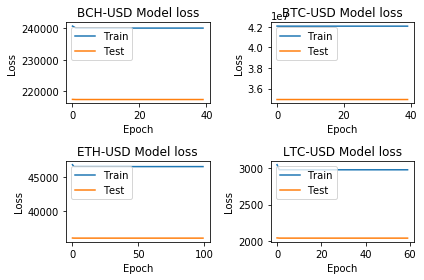

In [101]:
time_unit = 60
look_back = time_unit * 2
look_forward = time_unit * 1
epoches = [40, 40, 100, 60]

models = {}
history = {}

for i in range(4):
    curr = currencies[i]
    epoch = epoches[i]
    
    print(f'{curr} data processing')
    data_curr = data[curr][['avg']]
    data_curr = data_curr.reset_index().drop_duplicates(subset='time', keep='first')
    data_curr = data_curr.set_index('time')
    test = data_test[curr][['avg']]
    
    train_x, train_y = create_dataset(data_curr.values, look_back, look_forward)
    test_x, test_y = create_dataset(test.values, look_back, look_forward)
    
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    print(train_x.shape)
    
    print(f'{curr} model training')
    model_curr, history = train_model(f'{curr}_model_0911_avg_tanh', train_x, train_y, val_data=(test_x, test_y), epoches=epoch, batch_size=2)
    models[curr] = model_curr
    
    # Plot training & validation loss values
    plt.subplot(2, 2, i+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{curr} Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'Model_history_0911_avg_tanh.png'))
plt.show()


In [113]:
# plot_model(models['BCH-USD'], to_file=os.path.join(report_folder, 'lstm_model.png'))

In [112]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
models = {}
for i in range(4):
    curr = currencies[i]
    models[curr] = load_model(os.path.join(model_folder, f'{curr}_model_0911_avg_tanh.h5'))

In [84]:
data = load_data(['20181111_20181118'])
time_unit = 60
look_back = time_unit * 2
look_forward = time_unit * 1

load data from 20181111_20181118


In [ ]:
for curr in currencies:
    print(f'{curr} data processing')
    data_curr = data[curr][['avg']]
    train_x, train_y = create_dataset(data_curr.values, look_back, look_forward)
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    print(train_x.shape)
    
    

In [86]:
data_curr = data['ETH-USD'][['avg']]
train_x, train_y = create_dataset(data_curr.values, look_back, look_forward)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
predict_y = models['ETH-USD'].predict(train_x)

In [102]:
from xgboost import XGBRegressor

In [124]:
for i in range(4):
    curr = currencies[i]
    epoch = epoches[i]
    
    print(f'{curr} data processing')
    data_curr = data[curr][['avg']]
    data_curr = data_curr.reset_index().drop_duplicates(subset='time', keep='first')
    data_curr = data_curr.set_index('time')
    test = data_test[curr][['avg']]
    
    train_x, train_y = create_dataset(data_curr.values, look_back, look_forward)
    test_x, test_y = create_dataset(test.values, look_back, look_forward)
   
    print(f'{curr} model training')
    m1 = XGBRegressor(booster='gblinear', n_estimators=1000, learning_rate=0.1, max_depth=5)
    m2 = XGBRegressor(booster='gblinear', n_estimators=1500, learning_rate=0.1, max_depth=5)
    m3 = XGBRegressor(booster='gblinear', n_estimators=2000, learning_rate=0.1, max_depth=3)
    m1.fit(train_x, train_y)
    m2.fit(train_x, train_y)
    m3.fit(train_x, train_y)
    models[curr] = [m1, m2, m3]

BCH-USD data processing
BCH-USD model training
BTC-USD data processing
BTC-USD model training
ETH-USD data processing
ETH-USD model training
LTC-USD data processing
LTC-USD model training


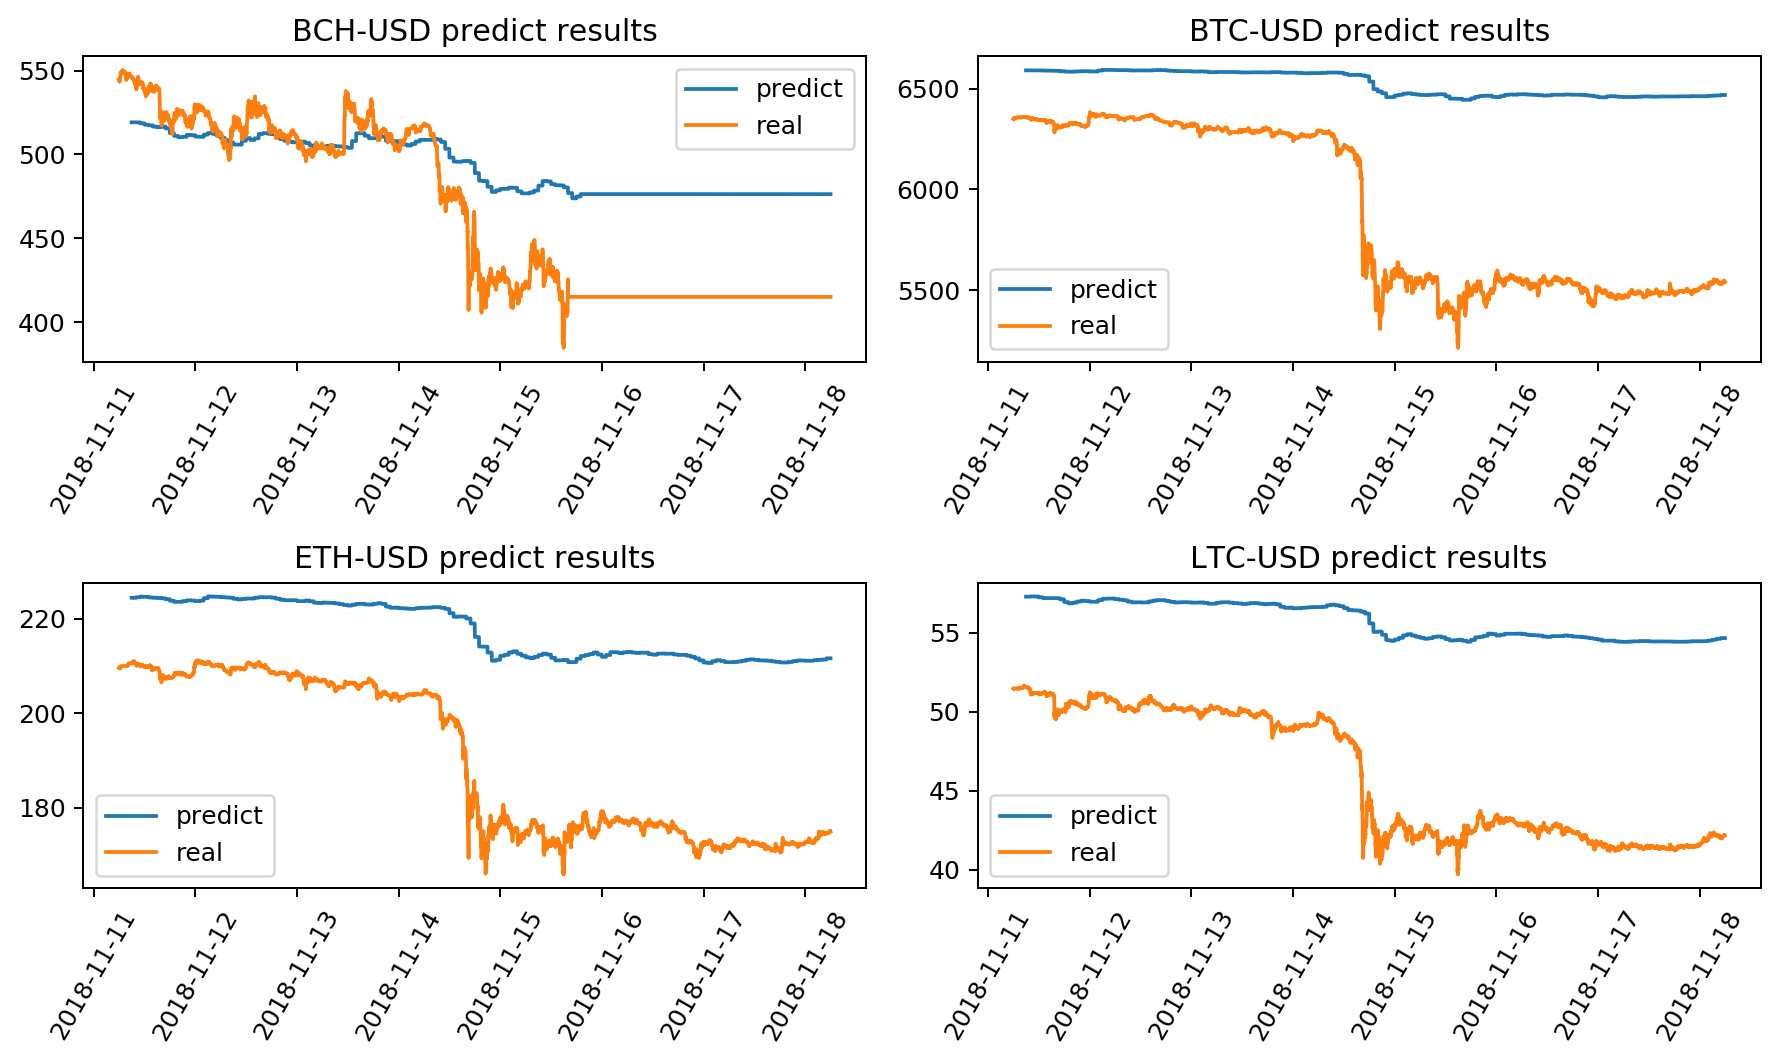

In [125]:
plt.figure(figsize=(10, 6), dpi=180)
for i in range(4):
    curr = currencies[i]
    asset_df = data_test[curr][['avg']]
    test_x, _ = create_dataset(asset_df.values, look_back, look_forward)
#     test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    y1 = models[curr][0].predict(test_x)
    y2 = models[curr][1].predict(test_x)
    y3 = models[curr][2].predict(test_x)
    
    count = 0
    list_y = np.array([])
    while count < len(asset_df):
        index = int(count/look_forward) - 3
        if index < 0:
            list_y = np.append(list_y, np.nan)
        else:
            list_y = np.append(list_y, (y1[index]+y2[index]+y3[index])/3)
        count+=1
    
    asset_df['predict'] = list_y
    
    plt.subplot(2,2,i+1)
    plt.plot(asset_df.index, asset_df['predict'], label='predict')
    plt.plot(asset_df.index, asset_df['avg'], label='real')
    plt.xticks(rotation=60)
    plt.title(f'{curr} predict results')
    plt.legend()
    
plt.tight_layout()
plt.savefig('./lstm_1h_1118.png')
plt.show()

In [128]:
for key, value in models.items():
    for i in range(3):
        joblib.dump(value[i], os.path.join(model_folder, f'xg_{key.lower()}_{i}.joblib'))

load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111
